In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import timedelta, datetime
import numpy as np
from pathlib import Path
import os
import re
from glob import glob

import matplotlib.dates as mdates

from logger import *

In [2]:
# load data
FILE_STATS = './henryk-stats.csv'
df = pd.read_csv(FILE_STATS)

# convert date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')  

# Prepare data

In [3]:
# selector
# df_from_me = df[ df['kind'] == 'Henryk' ]

"""
calculate scalar values
- total duration
- total count
"""
total_duration_s = df['duration'].sum()
total_duration_h = total_duration_s / 3600
total_duration_d = np.floor(total_duration_h / 24)
total_duration_d_h = total_duration_h - total_duration_d * 24
date_min = df['date'].min()
date_max = df['date'].max()

"""
duration of the recordings, group them by day
and perform moving average on them
"""
df_duration_by_date = df.groupby('date')['duration'].sum() / 60
df_duration_by_date =  df_duration_by_date.to_frame()['duration'].to_frame() \
    .rolling(14, closed='both', center=True).mean()
df_duration_by_date = df_duration_by_date.bfill().ffill() # fill nulls after rolling average

# display(df_duration_by_date)

"""
count of the recordings (per week) 
and index them by the 'week of' date column
and next average them by month (4 weeks)
"""

df_count_by_week = df.copy()
df_count_by_week['week'] = df['date'].dt.strftime('%Y') + '-' + df['date'].dt.strftime('%W')
df_count_by_week = df_count_by_week.groupby('week').agg({'date':['min'], 'name' : ['count']})
df_count_by_week = df_count_by_week.droplevel(axis=1, level=1).rename(columns={'name':'count'}) \
    .reset_index().set_index('date').drop('week', axis=1)
df_count_by_week.iloc[[0,-1],[0]] = None # remove count value from first and last row, because weeks are incomplete
df_count_by_week = df_count_by_week['count'].to_frame().rolling(1, closed='both', center=True).mean()
df_count_by_week = df_count_by_week.bfill().ffill() # fill nulls after rolling average
df_count_by_week['count'] = df_count_by_week['count'].round()

# display(df_count_by_week)

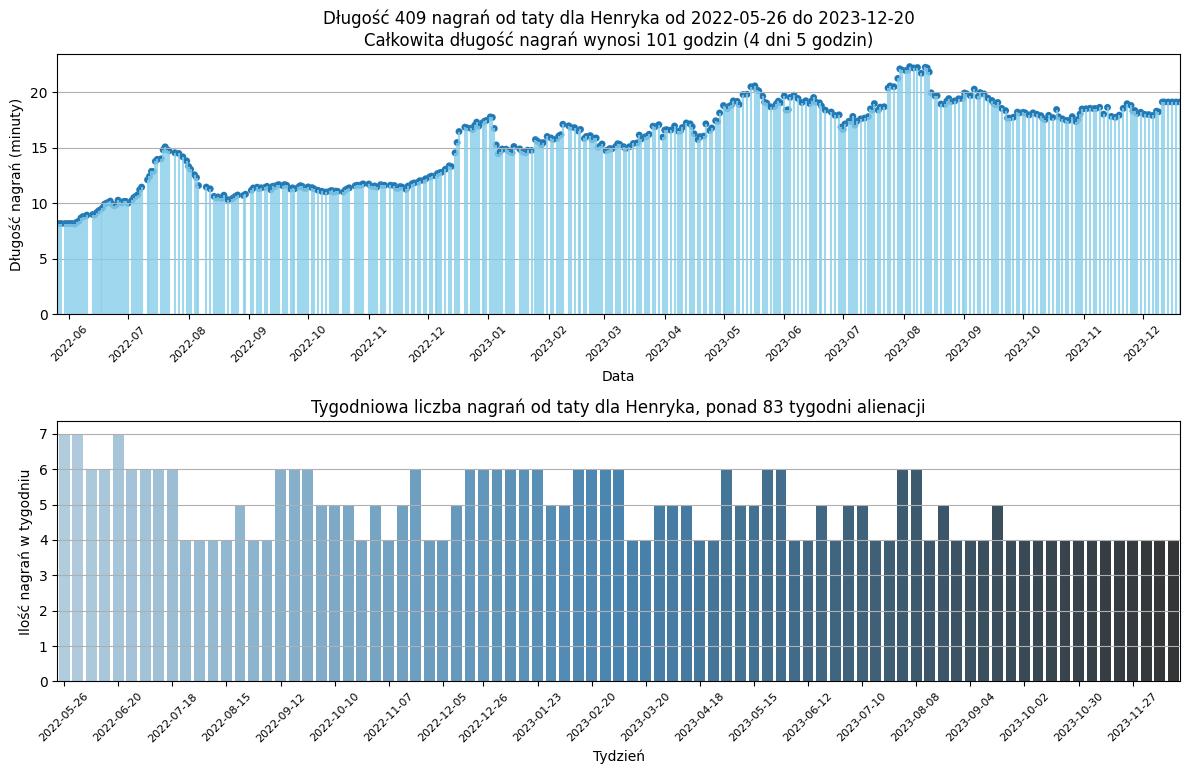

In [10]:
"""
plot the statistics
"""

# plot number of minutes / day
fig, axs = plt.subplots(2, 1, figsize=(12,8))
sns.scatterplot(ax=axs[0], data=df_duration_by_date, linewidth=0.05, s=25, alpha=1)
axs[0].vlines(x=df_duration_by_date.index, ymin=0, ymax=df_duration_by_date['duration'], color='skyblue', alpha =0.8)
axs[0].set_title(f'Długość {len(df)} nagrań od taty dla Henryka od {date_min.date()} do {date_max.date()}' 
             + '\n' + f'Całkowita długość nagrań wynosi {total_duration_h:,.0f} godzin ({total_duration_d:,.0f} dni {total_duration_d_h:.0f} godzin)' )
axs[0].grid(axis='y')
axs[0].legend(loc='upper right', labels=['Długość nagrań dla Henryka'])
axs[0].get_legend().remove()
axs[0].tick_params(axis='x', labelrotation=45, labelsize=8)
axs[0].set_ylabel("Długość nagrań (minuty)")
axs[0].set_xlabel("Data")
axs[0].set_xlim( (date_min, date_max) )
axs[0].set_ylim( bottom=0 )
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=14, maxticks=22))   #to get a tick every 15 minutes

# plot number of recordings / week
sns.barplot(ax=axs[1], x=df_count_by_week.index, hue=df_count_by_week.index, y=df_count_by_week['count'], palette='Blues_d', legend=False)
axs[1].set_title(f'Tygodniowa liczba nagrań od taty dla Henryka, ponad {len(df_count_by_week)} tygodni alienacji' )
axs[1].grid(axis='y')
axs[1].set_ylabel("Ilość nagrań w tygodniu")
axs[1].set_xlabel("Tydzień")
y_max = int(axs[1].get_ybound()[1])
axs[1].set_xticks( range(0,y_max) )
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=14, maxticks=22))   #to get a tick every 15 minutes
axs[1].tick_params(axis='x', labelrotation=45, labelsize=8)
fig.tight_layout(rect=[0, 0.01, 1, 0.99])
plt.show()

# References
- https://www.kaggle.com/code/robikscube/working-with-audio-in-python
- https://towardsdatascience.com/get-to-know-audio-feature-extraction-in-python-a499fdaefe42
- https://stackoverflow.com/questions/55669182/how-to-fix-filenotfounderror-winerror-2-the-system-cannot-find-the-file-speci

In [5]:
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
